In [1]:
!pip3 install --upgrade rouge-score bert-score nltk -q
!pip3 install evaluate -q
import nltk
nltk.download("punkt")
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet2022')

! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # fix for kaggle (https://www.kaggle.com/code/sharanharsoor/tutorial-word-sense-disambiguation)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.4 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.1 MB/s eta 0:00:0000:01


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import evaluate
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from bert_score import score
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from transformers import ViTModel, ViTImageProcessor, BartForConditionalGeneration, BartTokenizer
from transformers.modeling_outputs import BaseModelOutput
from tqdm import tqdm

## Dataset and Model

In [ ]:
class MOREDataset(Dataset):
    def __init__(self, image_descriptions_file, detected_objects_file, data_file, image_dir, tokenizer, detection_threshold=0.6, max_inp_length=256, max_output_length=128):
        with open(image_descriptions_file, "rb") as f:
            self.image_descriptions = pickle.load(f)
        with open(detected_objects_file, "rb") as f:
            self.detected_objects = pickle.load(f)
        
        self.row_data = pd.read_csv(data_file, sep="\t", index_col=0)
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.max_inp_length = max_inp_length
        self.max_output_length = max_output_length
        self.detection_threshold = detection_threshold

        detected_objs = {}
        for image_id, objects in self.detected_objects.items():
            detected_objs[image_id] = " ".join([str(objects["classes"][i]) for i in range(len(objects["classes"])) if objects["confidence_scores"][i] > self.detection_threshold])

        self.detected_objects = detected_objs

        self.row_data["detected_objects"] = self.row_data["pid"].map(self.detected_objects).fillna("")
        self.row_data["image_description"] = self.row_data["pid"].map(self.image_descriptions).fillna("")
        self.row_data["image_path"] = self.row_data["pid"].apply(lambda x: os.path.join(self.image_dir, x + ".jpg"))
        self.row_data["text"] = self.row_data["text"].astype(str).fillna("")
        self.row_data["explanation"] = self.row_data["explanation"].astype(str).fillna("")
        self.row_data["target_of_sarcasm"] = self.row_data["target_of_sarcasm"].astype(str).fillna("")

        self.row_data["combined_input"] = self.row_data["text"] + " " + self.row_data["image_description"] + " " + self.row_data["detected_objects"] + " " + self.row_data["target_of_sarcasm"]

    def __len__(self):
        return len(self.row_data)
    
    def __getitem__(self, index):
        row = self.row_data.iloc[index]
        image_path = row["image_path"]

        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file {image_path} not found.")

        image = Image.open(image_path).convert("RGB")
        combined_input = row["combined_input"]
        explaination = row["explanation"]

        input_embeddings = self.tokenizer(
            combined_input,
            padding="max_length",
            truncation=True,
            max_length=self.max_inp_length,
            return_tensors="pt"
        )

        output_embeddings = self.tokenizer(
            explaination,
            padding="max_length",
            truncation=True,
            max_length=self.max_output_length,
            return_tensors="pt"
        )

        return {
            "input_ids": input_embeddings["input_ids"].squeeze(0),
            "attention_mask": input_embeddings["attention_mask"].squeeze(0),
            "labels": output_embeddings["input_ids"].squeeze(0),
            "image": image
        }
    
class TURBOModel(nn.Module):
    def __init__(self, fusion_dim=768):
        super(TURBOModel, self).__init__()

        self.vision_transformer = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.image_feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

        self.bart = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

        self.img_feature_proj = nn.Linear(self.vision_transformer.config.hidden_size, fusion_dim)

        self.text_attention = nn.MultiheadAttention(embed_dim=fusion_dim, num_heads=8, batch_first=True)
        self.img_attention = nn.MultiheadAttention(embed_dim=fusion_dim, num_heads=8, batch_first=True)
        
        self.gated_fusion_img = nn.Linear(fusion_dim, fusion_dim)
        self.gated_fusion_text = nn.Linear(fusion_dim, fusion_dim)

        self.fusion_weights = nn.Parameter(torch.ones(4) / 4)

    def forward(self, images, input_ids, attention_mask, labels=None, inference=False):
        device = input_ids.device

        image_features = self.image_feature_extractor(images, return_tensors="pt").to(device)
        vit_outputs = self.vision_transformer(**image_features)

        image_features = self.img_feature_proj(vit_outputs.pooler_output)

        text_hidden_state = self.bart.model.encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        # gating from refernced paper
        _, seq_len, _ = text_hidden_state.size()
        img_features = image_features.unsqueeze(1).expand(-1, seq_len, -1)

        attention_img, _ = self.img_attention(img_features, img_features, img_features)
        attention_text, _ = self.text_attention(text_hidden_state, text_hidden_state, text_hidden_state)

        img_gateing = torch.sigmoid(self.gated_fusion_img(img_features))
        txt_gateing = torch.sigmoid(self.gated_fusion_text(text_hidden_state))

        Fvt = attention_text * img_features
        Ftv = attention_img * text_hidden_state

        F1 = (img_gateing * Ftv) + ((1 - img_gateing) * Fvt)
        F2 = (txt_gateing * Ftv) + ((1 - txt_gateing) * Fvt)

        F3 = (img_gateing * img_features) + ((1 - img_gateing) * Ftv)
        F4 = (txt_gateing * text_hidden_state) + ((1 - txt_gateing) * Fvt)

        combined_fusion = self.fusion_weights[0] * F1 + self.fusion_weights[1] * F2 + self.fusion_weights[2] * F3 + self.fusion_weights[3] * F4
        Z = text_hidden_state + combined_fusion

        bart_decoder_input = BaseModelOutput(last_hidden_state=Z)

        if not inference:
            outputs = self.bart(
                encoder_outputs=bart_decoder_input,
                attention_mask=attention_mask,
                labels=labels
            )
            
        else:
            outputs = self.bart.generate(
                encoder_outputs=bart_decoder_input,
                attention_mask=attention_mask,
                max_length=self.bart.config.max_length,
                num_beams=5,
                early_stopping=True
            )
            
        return outputs

def evaluate_model(model, val_loader, device, tokenizer):
    model.eval()
    total_loss = 0.0
    predictions = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            images = batch['image']
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(images, input_ids, attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            generated = model(images, input_ids, attention_mask, inference=True)
            decoded_preds = tokenizer.batch_decode(generated, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
            
            for pred, label in zip(decoded_preds, decoded_labels):
                predictions.append({"prediction": pred, "reference": label})
                
    avg_loss = total_loss / len(val_loader)

    preds = [item["prediction"] for item in predictions]
    refs = [item["reference"] for item in predictions]

    # ROUGE Calculation
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {metric: 0.0 for metric in ['rouge1', 'rouge2', 'rougeL']}
    for pred, ref in zip(preds, refs):
        scores = scorer.score(ref, pred)
        for metric in rouge_scores:
            rouge_scores[metric] += scores[metric].fmeasure
    for metric in rouge_scores:
        rouge_scores[metric] /= len(preds)

    # BLEU Calculation
    raw_refs = [[r] for r in refs]  
    raw_preds = preds

    bleu_metric = evaluate.load("bleu")
    bleu1 = bleu_metric.compute(predictions=raw_preds, references=raw_refs, max_order=1)
    bleu2 = bleu_metric.compute(predictions=raw_preds, references=raw_refs, max_order=2)
    bleu3 = bleu_metric.compute(predictions=raw_preds, references=raw_refs, max_order=3)
    bleu4 = bleu_metric.compute(predictions=raw_preds, references=raw_refs, max_order=4)

    # METEOR Calculation
    meteor_scores = []
    for pred, ref in zip(preds, refs):
        meteor_scores.append(meteor_score([ref.split()], pred.split()))
    avg_meteor = sum(meteor_scores) / len(meteor_scores)
    
    P, R, F1 = score(preds, refs, lang="en", verbose=False) 
    bert_precision = P.mean().item()
    bert_recall = R.mean().item()
    bert_f1 = F1.mean().item()

    metrics = {
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "Evaluate BLEU-1" : bleu1['bleu'],
        "Evaluate BLEU-2" : bleu2['bleu'],
        "Evaluate BLEU-3" : bleu3['bleu'],
        "Evaluate BLEU-4" : bleu4['bleu'],
        "METEOR": avg_meteor,
        "BERT Precision": bert_precision,
        "BERT Recall" : bert_recall,
        "BERT F1": bert_f1
    }
    
    return avg_loss, metrics

def train_model(model, train_loader, val_loader, optimizer, device, tokenizer, num_epochs=3):
    model.to(device)
    best_loss = float("inf")
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        sum_loss = 0.0

        for batch in tqdm(train_loader, desc="Training"):
            images = batch['image']
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(images, input_ids, attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            sum_loss += loss.item()

        avg_train_loss = sum_loss / len(train_loader)
        print(f"Training Loss: {avg_train_loss:.4f}")

        val_loss, metrics = evaluate_model(model, val_loader, device, tokenizer)
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"ROUGE-1: {metrics['ROUGE-1']:.4f}")
        print(f"ROUGE-2: {metrics['ROUGE-2']:.4f}")
        print(f"ROUGE-L: {metrics['ROUGE-L']:.4f}")
        print(f"BLEU-1: {metrics['Evaluate BLEU-1']:.4f}")
        print(f"BLEU-2: {metrics['Evaluate BLEU-2']:.4f}")
        print(f"BLEU-3: {metrics['Evaluate BLEU-3']:.4f}")
        print(f"BLEU-4: {metrics['Evaluate BLEU-4']:.4f}")
        print(f"METEOR: {metrics['METEOR']:.4f}")
        print(f"BERTscore Precision: {metrics['BERT Precision']:.4f}")
        print(f"BERTscore Recall: {metrics['BERT Recall']:.4f}")
        print(f"BERTscore F1: {metrics['BERT F1']:.4f}")

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)

        torch.save(model.state_dict(), f"TURBOModel_epoch{epoch+1}.pth")
        print(f"Saved model checkpoint for epoch {epoch+1}")

        if val_loss < best_loss:
            best_loss = val_loss
            print(f"New best model found at epoch {epoch+1}, saving as best model...")
            torch.save(model.state_dict(), "TURBOModel_best.pth")

    return train_losses, val_losses
          
def custom_collate_fn(batch):
    return {
        'image': [item['image'] for item in batch],
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'labels': torch.stack([item['labels'] for item in batch])
    }

## Model Training

In [4]:
text_tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

train_dataset = MOREDataset(
    image_descriptions_file="/kaggle/input/nlp-q3/D_train.pkl",
    detected_objects_file="/kaggle/input/nlp-q3/O_train.pkl",
    data_file="/kaggle/input/nlp-q3/train_df.tsv",
    image_dir="/kaggle/input/nlp-q3/images",
    tokenizer=text_tokenizer,
    detection_threshold=0.6,
    max_inp_length=256,
    max_output_length=128
)

val_dataset = MOREDataset(
    image_descriptions_file="/kaggle/input/nlp-q3/D_val.pkl",
    detected_objects_file="/kaggle/input/nlp-q3/O_val.pkl",
    data_file="/kaggle/input/nlp-q3/val_df.tsv",
    image_dir="/kaggle/input/nlp-q3/images",
    tokenizer=text_tokenizer,
    detection_threshold=0.6,
    max_inp_length=256,
    max_output_length=128
)

model = TURBOModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate_fn, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn, pin_memory=True)

train_losses, val_losses = train_model(model, train_dataloader, val_dataloader, optimizer, device, text_tokenizer, num_epochs=20)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Epoch 1/20


Training: 100%|██████████| 187/187 [05:25<00:00,  1.74s/it]


Training Loss: 5.1527


Evaluating: 100%|██████████| 11/11 [00:21<00:00,  1.99s/it]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 1.2166
ROUGE-1: 0.4732
ROUGE-2: 0.3041
ROUGE-L: 0.4432
BLEU-1: 0.4236
BLEU-2: 0.3438
BLEU-3: 0.2877
BLEU-4: 0.2457
METEOR: 0.3496
BERTscore Precision: 0.9059
BERTscore Recall: 0.8996
BERTscore F1: 0.9025
Saved model checkpoint for epoch 1
New best model found at epoch 1, saving as best model...
Epoch 2/20


Training: 100%|██████████| 187/187 [05:14<00:00,  1.68s/it]


Training Loss: 0.7828


Evaluating: 100%|██████████| 11/11 [00:20<00:00,  1.90s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.3279
ROUGE-1: 0.4839
ROUGE-2: 0.3213
ROUGE-L: 0.4568
BLEU-1: 0.4419
BLEU-2: 0.3621
BLEU-3: 0.3061
BLEU-4: 0.2620
METEOR: 0.3759
BERTscore Precision: 0.9103
BERTscore Recall: 0.9014
BERTscore F1: 0.9055
Saved model checkpoint for epoch 2
New best model found at epoch 2, saving as best model...
Epoch 3/20


Training: 100%|██████████| 187/187 [05:13<00:00,  1.68s/it]


Training Loss: 0.3432


Evaluating: 100%|██████████| 11/11 [00:20<00:00,  1.89s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.2522
ROUGE-1: 0.5050
ROUGE-2: 0.3448
ROUGE-L: 0.4789
BLEU-1: 0.4520
BLEU-2: 0.3758
BLEU-3: 0.3216
BLEU-4: 0.2785
METEOR: 0.4006
BERTscore Precision: 0.9171
BERTscore Recall: 0.9066
BERTscore F1: 0.9115
Saved model checkpoint for epoch 3
New best model found at epoch 3, saving as best model...
Epoch 4/20


Training: 100%|██████████| 187/187 [05:13<00:00,  1.68s/it]


Training Loss: 0.2717


Evaluating: 100%|██████████| 11/11 [00:20<00:00,  1.90s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.2280
ROUGE-1: 0.5186
ROUGE-2: 0.3666
ROUGE-L: 0.4966
BLEU-1: 0.4581
BLEU-2: 0.3862
BLEU-3: 0.3340
BLEU-4: 0.2930
METEOR: 0.4212
BERTscore Precision: 0.9194
BERTscore Recall: 0.9080
BERTscore F1: 0.9135
Saved model checkpoint for epoch 4
New best model found at epoch 4, saving as best model...
Epoch 5/20


Training: 100%|██████████| 187/187 [05:14<00:00,  1.68s/it]


Training Loss: 0.2410


Evaluating: 100%|██████████| 11/11 [00:20<00:00,  1.89s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.2149
ROUGE-1: 0.5158
ROUGE-2: 0.3616
ROUGE-L: 0.4939
BLEU-1: 0.4582
BLEU-2: 0.3861
BLEU-3: 0.3341
BLEU-4: 0.2931
METEOR: 0.4109
BERTscore Precision: 0.9216
BERTscore Recall: 0.9096
BERTscore F1: 0.9153
Saved model checkpoint for epoch 5
New best model found at epoch 5, saving as best model...
Epoch 6/20


Training: 100%|██████████| 187/187 [05:14<00:00,  1.68s/it]


Training Loss: 0.2223


Evaluating: 100%|██████████| 11/11 [00:20<00:00,  1.89s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.2076
ROUGE-1: 0.5239
ROUGE-2: 0.3693
ROUGE-L: 0.5019
BLEU-1: 0.4616
BLEU-2: 0.3889
BLEU-3: 0.3371
BLEU-4: 0.2971
METEOR: 0.4211
BERTscore Precision: 0.9218
BERTscore Recall: 0.9107
BERTscore F1: 0.9160
Saved model checkpoint for epoch 6
New best model found at epoch 6, saving as best model...
Epoch 7/20


Training: 100%|██████████| 187/187 [05:14<00:00,  1.68s/it]


Training Loss: 0.2081


Evaluating: 100%|██████████| 11/11 [00:20<00:00,  1.89s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.2037
ROUGE-1: 0.5323
ROUGE-2: 0.3762
ROUGE-L: 0.5087
BLEU-1: 0.4587
BLEU-2: 0.3868
BLEU-3: 0.3369
BLEU-4: 0.2980
METEOR: 0.4199
BERTscore Precision: 0.9239
BERTscore Recall: 0.9118
BERTscore F1: 0.9176
Saved model checkpoint for epoch 7
New best model found at epoch 7, saving as best model...
Epoch 8/20


Training: 100%|██████████| 187/187 [05:14<00:00,  1.68s/it]


Training Loss: 0.1956


Evaluating: 100%|██████████| 11/11 [00:20<00:00,  1.90s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1993
ROUGE-1: 0.5341
ROUGE-2: 0.3774
ROUGE-L: 0.5108
BLEU-1: 0.4723
BLEU-2: 0.4007
BLEU-3: 0.3497
BLEU-4: 0.3100
METEOR: 0.4326
BERTscore Precision: 0.9230
BERTscore Recall: 0.9122
BERTscore F1: 0.9173
Saved model checkpoint for epoch 8
New best model found at epoch 8, saving as best model...
Epoch 9/20


Training: 100%|██████████| 187/187 [05:15<00:00,  1.69s/it]


Training Loss: 0.1862


Evaluating: 100%|██████████| 11/11 [00:21<00:00,  1.91s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1972
ROUGE-1: 0.5313
ROUGE-2: 0.3733
ROUGE-L: 0.5106
BLEU-1: 0.4633
BLEU-2: 0.3902
BLEU-3: 0.3398
BLEU-4: 0.3008
METEOR: 0.4222
BERTscore Precision: 0.9234
BERTscore Recall: 0.9115
BERTscore F1: 0.9172
Saved model checkpoint for epoch 9
New best model found at epoch 9, saving as best model...
Epoch 10/20


Training: 100%|██████████| 187/187 [05:13<00:00,  1.68s/it]


Training Loss: 0.1770


Evaluating: 100%|██████████| 11/11 [00:20<00:00,  1.89s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1970
ROUGE-1: 0.5394
ROUGE-2: 0.3837
ROUGE-L: 0.5160
BLEU-1: 0.4723
BLEU-2: 0.3988
BLEU-3: 0.3477
BLEU-4: 0.3077
METEOR: 0.4320
BERTscore Precision: 0.9241
BERTscore Recall: 0.9134
BERTscore F1: 0.9185
Saved model checkpoint for epoch 10
New best model found at epoch 10, saving as best model...
Epoch 11/20


Training: 100%|██████████| 187/187 [05:13<00:00,  1.68s/it]


Training Loss: 0.1703


Evaluating: 100%|██████████| 11/11 [00:20<00:00,  1.89s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1944
ROUGE-1: 0.5343
ROUGE-2: 0.3752
ROUGE-L: 0.5086
BLEU-1: 0.4643
BLEU-2: 0.3887
BLEU-3: 0.3359
BLEU-4: 0.2951
METEOR: 0.4245
BERTscore Precision: 0.9238
BERTscore Recall: 0.9115
BERTscore F1: 0.9174
Saved model checkpoint for epoch 11
New best model found at epoch 11, saving as best model...
Epoch 12/20


Training: 100%|██████████| 187/187 [05:14<00:00,  1.68s/it]


Training Loss: 0.1615


Evaluating: 100%|██████████| 11/11 [00:20<00:00,  1.91s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1942
ROUGE-1: 0.5483
ROUGE-2: 0.3900
ROUGE-L: 0.5213
BLEU-1: 0.4767
BLEU-2: 0.4043
BLEU-3: 0.3544
BLEU-4: 0.3153
METEOR: 0.4372
BERTscore Precision: 0.9263
BERTscore Recall: 0.9145
BERTscore F1: 0.9201
Saved model checkpoint for epoch 12
New best model found at epoch 12, saving as best model...
Epoch 13/20


Training: 100%|██████████| 187/187 [05:15<00:00,  1.69s/it]


Training Loss: 0.1561


Evaluating: 100%|██████████| 11/11 [00:21<00:00,  1.93s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1952
ROUGE-1: 0.5541
ROUGE-2: 0.3915
ROUGE-L: 0.5253
BLEU-1: 0.4818
BLEU-2: 0.4063
BLEU-3: 0.3543
BLEU-4: 0.3122
METEOR: 0.4430
BERTscore Precision: 0.9249
BERTscore Recall: 0.9140
BERTscore F1: 0.9192
Saved model checkpoint for epoch 13
Epoch 14/20


Training: 100%|██████████| 187/187 [05:16<00:00,  1.69s/it]


Training Loss: 0.1483


Evaluating: 100%|██████████| 11/11 [00:21<00:00,  1.92s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1943
ROUGE-1: 0.5600
ROUGE-2: 0.4041
ROUGE-L: 0.5337
BLEU-1: 0.4883
BLEU-2: 0.4150
BLEU-3: 0.3631
BLEU-4: 0.3220
METEOR: 0.4538
BERTscore Precision: 0.9272
BERTscore Recall: 0.9156
BERTscore F1: 0.9212
Saved model checkpoint for epoch 14
Epoch 15/20


Training: 100%|██████████| 187/187 [05:16<00:00,  1.69s/it]


Training Loss: 0.1409


Evaluating: 100%|██████████| 11/11 [00:21<00:00,  1.93s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1941
ROUGE-1: 0.5529
ROUGE-2: 0.3906
ROUGE-L: 0.5281
BLEU-1: 0.4818
BLEU-2: 0.4070
BLEU-3: 0.3545
BLEU-4: 0.3127
METEOR: 0.4401
BERTscore Precision: 0.9267
BERTscore Recall: 0.9152
BERTscore F1: 0.9207
Saved model checkpoint for epoch 15
New best model found at epoch 15, saving as best model...
Epoch 16/20


Training: 100%|██████████| 187/187 [05:17<00:00,  1.70s/it]


Training Loss: 0.1343


Evaluating: 100%|██████████| 11/11 [00:21<00:00,  1.92s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1953
ROUGE-1: 0.5562
ROUGE-2: 0.3954
ROUGE-L: 0.5280
BLEU-1: 0.4809
BLEU-2: 0.4063
BLEU-3: 0.3535
BLEU-4: 0.3107
METEOR: 0.4479
BERTscore Precision: 0.9258
BERTscore Recall: 0.9148
BERTscore F1: 0.9200
Saved model checkpoint for epoch 16
Epoch 17/20


Training: 100%|██████████| 187/187 [05:17<00:00,  1.70s/it]


Training Loss: 0.1275


Evaluating: 100%|██████████| 11/11 [00:21<00:00,  1.93s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1968
ROUGE-1: 0.5513
ROUGE-2: 0.3843
ROUGE-L: 0.5225
BLEU-1: 0.4846
BLEU-2: 0.4072
BLEU-3: 0.3547
BLEU-4: 0.3120
METEOR: 0.4401
BERTscore Precision: 0.9239
BERTscore Recall: 0.9149
BERTscore F1: 0.9192
Saved model checkpoint for epoch 17
Epoch 18/20


Training: 100%|██████████| 187/187 [05:16<00:00,  1.69s/it]


Training Loss: 0.1226


Evaluating: 100%|██████████| 11/11 [00:21<00:00,  1.93s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1983
ROUGE-1: 0.5727
ROUGE-2: 0.4091
ROUGE-L: 0.5459
BLEU-1: 0.4939
BLEU-2: 0.4186
BLEU-3: 0.3651
BLEU-4: 0.3225
METEOR: 0.4538
BERTscore Precision: 0.9280
BERTscore Recall: 0.9168
BERTscore F1: 0.9222
Saved model checkpoint for epoch 18
Epoch 19/20


Training: 100%|██████████| 187/187 [05:16<00:00,  1.69s/it]


Training Loss: 0.1149


Evaluating: 100%|██████████| 11/11 [00:21<00:00,  1.93s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.2017
ROUGE-1: 0.5672
ROUGE-2: 0.4038
ROUGE-L: 0.5387
BLEU-1: 0.4941
BLEU-2: 0.4195
BLEU-3: 0.3680
BLEU-4: 0.3266
METEOR: 0.4570
BERTscore Precision: 0.9256
BERTscore Recall: 0.9162
BERTscore F1: 0.9207
Saved model checkpoint for epoch 19
Epoch 20/20


Training: 100%|██████████| 187/187 [05:17<00:00,  1.70s/it]


Training Loss: 0.1072


Evaluating: 100%|██████████| 11/11 [00:21<00:00,  1.93s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.2037
ROUGE-1: 0.5664
ROUGE-2: 0.3972
ROUGE-L: 0.5380
BLEU-1: 0.4884
BLEU-2: 0.4109
BLEU-3: 0.3589
BLEU-4: 0.3177
METEOR: 0.4468
BERTscore Precision: 0.9275
BERTscore Recall: 0.9169
BERTscore F1: 0.9219
Saved model checkpoint for epoch 20


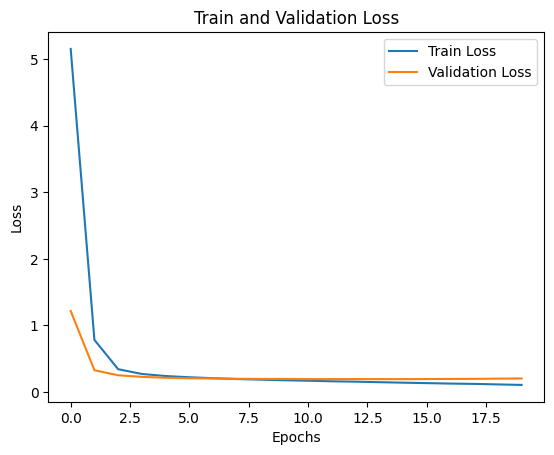

In [5]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

## Inference

In [ ]:
def test_model(image_descriptions_file, detected_objects_file, data_file, image_dir, device):
    text_tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

    test_dataset = MOREDataset(
        image_descriptions_file=image_descriptions_file,
        detected_objects_file=detected_objects_file,
        data_file=data_file,
        image_dir=image_dir,
        tokenizer=text_tokenizer,
        detection_threshold=0.6,
        max_inp_length=256,
        max_output_length=128
    )
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn, pin_memory=True)

    model = TURBOModel()
    model.load_state_dict(torch.load("TURBOModel_best.pth", weights_only=True))
    
    model.eval()
    model.to(device)

    global predictions

    predictions = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            images = batch['image']
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(images, input_ids, attention_mask, inference=True)

            decoded_preds = text_tokenizer.batch_decode(outputs, skip_special_tokens=True)
            decoded_labels = text_tokenizer.batch_decode(labels, skip_special_tokens=True)
            
            for pred, label in zip(decoded_preds, decoded_labels):
                predictions.append({"prediction": pred, "reference": label})
    
    preds = [item["prediction"] for item in predictions]
    refs = [item["reference"] for item in predictions]
    
    # ROUGE Calculation
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {metric: 0.0 for metric in ['rouge1', 'rouge2', 'rougeL']}
    for pred, ref in zip(preds, refs):
        scores = scorer.score(ref, pred)
        for metric in rouge_scores:
            rouge_scores[metric] += scores[metric].fmeasure
    for metric in rouge_scores:
        rouge_scores[metric] /= len(preds)

    # BLEU Calculation
    raw_refs = [[r] for r in refs]  
    raw_preds = preds

    bleu_metric = evaluate.load("bleu")
    bleu1 = bleu_metric.compute(predictions=raw_preds, references=raw_refs, max_order=1)
    bleu2 = bleu_metric.compute(predictions=raw_preds, references=raw_refs, max_order=2)
    bleu3 = bleu_metric.compute(predictions=raw_preds, references=raw_refs, max_order=3)
    bleu4 = bleu_metric.compute(predictions=raw_preds, references=raw_refs, max_order=4)

    # METEOR Calculation
    meteor_scores = []
    for pred, ref in zip(preds, refs):
        meteor_scores.append(meteor_score([ref.split()], pred.split()))
    avg_meteor = sum(meteor_scores) / len(meteor_scores)
    
    # BERTScore Calculation
    P, R, F1 = score(preds, refs, lang="en", verbose=False) 
    bert_precision = P.mean().item()
    bert_recall = R.mean().item()
    bert_f1 = F1.mean().item()
    
    print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}")
    print(f"ROUGE-2: {rouge_scores['rouge2']:.4f}")
    print(f"ROUGE-L: {rouge_scores['rougeL']:.4f}")
    print(f"BLEU-1: {bleu1['bleu']}")
    print(f"BLEU-2: {bleu2['bleu']}")
    print(f"BLEU-3: {bleu3['bleu']}")
    print(f"BLEU-4: {bleu4['bleu']}")
    print(f"METEOR: {avg_meteor:.4f}")
    print(f"BERTscore Precision: {bert_precision:.4f}")
    print(f"BERTscore Recall: {bert_recall:.4f}")
    print(f"BERTscore F1: {bert_f1:.4f}")

    return predictions

test_model(
    image_descriptions_file="/kaggle/input/nlp-q3/D_val.pkl",
    detected_objects_file="/kaggle/input/nlp-q3/O_val.pkl",
    data_file="/kaggle/input/nlp-q3/val_df.tsv",
    image_dir="/kaggle/input/nlp-q3/images",
    device=device
)

100%|██████████| 11/11 [00:15<00:00,  1.42s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.5529
ROUGE-2: 0.3906
ROUGE-L: 0.5281
BLEU-1: 0.4818300863092168
BLEU-2: 0.4069671848734278
BLEU-3: 0.35445216525624906
BLEU-4: 0.3126999896540154
METEOR: 0.4401
BERTscore Precision: 0.9267
BERTscore Recall: 0.9152
BERTscore F1: 0.9207


[{'prediction': 'the author is pissed at <user> for such awful network in malad.',
  'reference': 'the author is pissed at <user> for not getting network in malad.'},
 {'prediction': 'the author hates waiting for an hour on the tarmac for a gate to come open',
  'reference': 'nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.'},
 {'prediction': "spring isn't the best thing about spring.",
  'reference': 'nobody likes getting one hour of their life sucked away.'},
 {'prediction': "having a salivary gland biopsy on monday morning isn't a good way",
  'reference': 'having a salivary gland biopsy on monday morning is not a good way to start the new week.'},
 {'prediction': "it's going to be freezing weather this w-end, the high on saturday",
  'reference': 'the author is worried that the weekend is going to be freezing with a high of -1 and windchill probably -30.'},
 {'prediction': 'the author is pissed at <user> for delaying the trains a